# With the new control and armflapping videos (shorter directories), let's see whether we can get a higher accuracy. 

In [1]:
import cv2, os 
import numpy as np 
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp


def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1; 
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [3]:
# time to actually do calibration. 

SECONDS_TO_DETECT = 2 # in seconds
DISTANCE_BETWEEN_INPUTS = 0.01 # in seconds, only matters if sampling is True
sampling = False 

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

armflapping_videos:  19%|█▉        | 21/108 [00:00<00:02, 37.86it/s]

failed on .DS_Store


control_videos:  24%|██▍       | 15/62 [00:00<00:02, 19.55it/s]

failed on .DS_Store


control_videos: 100%|██████████| 62/62 [00:02<00:00, 22.53it/s]


(97, 50)

In [4]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


In [5]:
print([len(video) for video in ARMFLAPPING_LOCATIONS])
print([len(video) for video in CONTROL_LOCATIONS])

[121, 61, 121, 90, 90, 90, 72, 90, 90, 49, 49, 90, 90, 90, 72, 90, 121, 49, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 121, 90, 90, 90, 90, 91, 90, 120, 90, 90, 121, 91, 90, 90, 90, 90, 45, 45, 121, 90, 90, 45, 90, 72, 60, 90, 90, 91, 91, 49, 91, 121, 90, 90, 72, 90, 72, 72, 49, 49, 90, 45, 72, 72, 120, 121, 90, 90, 72, 90, 90, 49, 72, 45, 72, 91, 90, 90, 97, 121, 49, 45, 72, 73, 60, 72, 90, 72]
[121, 121, 90, 90, 72, 72, 90, 91, 49, 49, 49, 61, 45, 72, 72, 72, 73, 90, 60, 121, 90, 49, 90, 90, 73, 90, 73, 49, 121, 90, 90, 90, 60, 90, 121, 90, 41, 121, 45, 60, 121, 90, 90, 121, 90, 61, 46, 45, 45, 121]


In [6]:
# to balance classes 
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

In [7]:
# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = np.array(locations).tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

50it [00:00, 17177.10it/s]
50it [00:00, 7898.88it/s]

(50, 90, 126) (50, 90, 126)


In [8]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [9]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array([test_frames])
    test_frames = pad(test_frames, maxlen = 90)
    
    return model.predict(test_frames)

In [10]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X


class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X):
        return tf.map_fn(_shift, X)
        
        

In [11]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('all_points_folds'): 
    with open(f"all_points_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [50]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across runs')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"run {i + 1}" for i in range(len(average_aurocs))] + ["average run"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across runs")
    plt.show()

In [54]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    AVERAGE_AUROCS, AVERAGE_TPRS = [], [] 
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [57]:
import random 
def shuffle(X, y, seed = None):
    if not seed:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 126)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y)

using seed 34


In [58]:
import tensorflow as tf 
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(),
        tf.keras.layers.LSTM(64, return_sequences=False), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

Epoch 1/75
3/3 [==============================] - 1s 247ms/step - loss: 0.6910 - accuracy: 0.4875 - precision_82: 0.5000 - recall_82: 0.6829 - val_loss: 0.6904 - val_accuracy: 0.4000 - val_precision_82: 0.4118 - val_recall_82: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 183ms/step - loss: 0.6559 - accuracy: 0.5375 - precision_82: 0.5278 - recall_82: 0.9268 - val_loss: 0.6930 - val_accuracy: 0.4000 - val_precision_82: 0.4118 - val_recall_82: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6419 - accuracy: 0.5875 - precision_82: 0.5571 - recall_82: 0.9512 - val_loss: 0.6972 - val_accuracy: 0.4000 - val_precision_82: 0.4118 - val_recall_82: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 177ms/step - loss: 0.6231 - accuracy: 0.6125 - precision_82: 0.5735 - recall_82: 0.9512 - val_loss: 0.7020 - val_accuracy: 0.4000 - val_precision_82: 0.4118 - val_recall_82: 0.7778
Epoch 5/75
3/3 [==============================] - 0s 154ms/step 

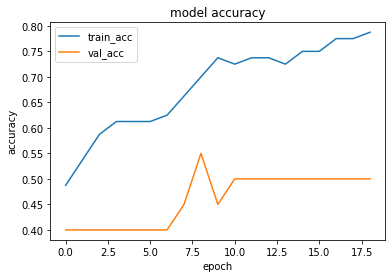

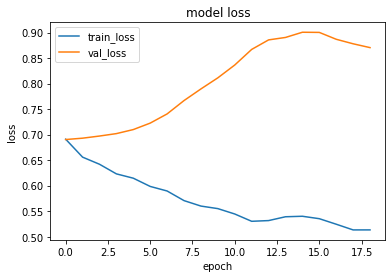

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.25356415]]


1it [00:00, 10512.04it/s]


prediction for video armflapping_3.mov is [[0.5988453]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.15694055]]


1it [00:00, 16448.25it/s]


prediction for video control_1.mov is [[0.06800681]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.86379075]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.0942938]]
Epoch 1/75
3/3 [==============================] - 1s 242ms/step - loss: 0.6903 - accuracy: 0.5500 - precision_83: 0.5283 - recall_83: 0.7179 - val_loss: 0.6533 - val_accuracy: 0.7000 - val_precision_83: 0.6471 - val_recall_83: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6790 - accuracy: 0.7250 - precision_83: 0.7179 - recall_83: 0.7179 - val_loss: 0.6387 - val_accuracy: 0.6000 - val_precision_83: 0.6000 - val_recall_83: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6762 - accuracy: 0.6750 - precision_83: 0.6667 - recall_83: 0.6667 - val_loss: 0.6245 - val_accuracy: 0.6000 - val_precision_83: 0.6000 - val_recall_83: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6731 - accuracy: 0.6625 - precision_83: 0.6500 - recall_83: 0.6667 - val_loss: 0.6129 - val_accuracy: 0.7000 - val_precision_83: 0.6471 - val_recall_83: 1.0000
Epoch 5/75
3

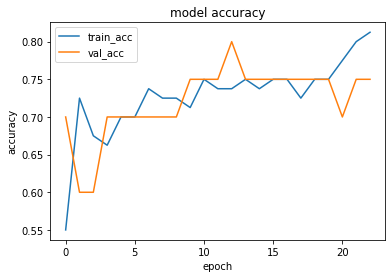

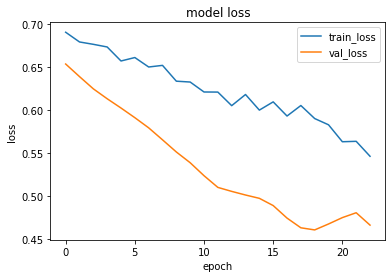

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.3246404]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5328063]]


1it [00:00, 8683.86it/s]


prediction for video armflapping_2.mov is [[0.17274144]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.14354768]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.7421627]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.19855589]]
Epoch 1/75
3/3 [==============================] - 1s 245ms/step - loss: 0.6935 - accuracy: 0.5625 - precision_84: 0.5667 - recall_84: 0.7907 - val_loss: 0.7146 - val_accuracy: 0.3500 - val_precision_84: 0.3500 - val_recall_84: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6789 - accuracy: 0.5125 - precision_84: 0.5263 - recall_84: 0.9302 - val_loss: 0.7065 - val_accuracy: 0.3500 - val_precision_84: 0.3500 - val_recall_84: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6789 - accuracy: 0.5750 - precision_84: 0.5600 - recall_84: 0.9767 - val_loss: 0.6988 - val_accuracy: 0.4500 - val_precision_84: 0.3889 - val_recall_84: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6446 - accuracy: 0.5750 - precision_84: 0.5616 - recall_84: 0.9535 - val_loss: 0.6888 - val_accuracy: 0.5000 - val_precision_84: 0.4118 - val_recall_84: 1.0000
Epoch 5/75


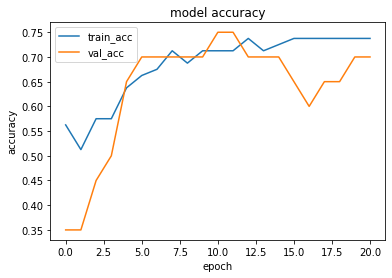

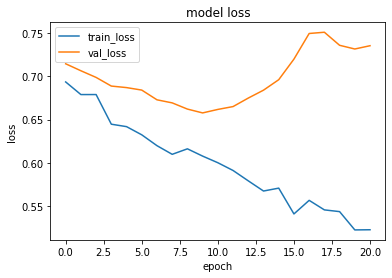

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.26378098]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.6166406]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.17956567]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.18885878]]


1it [00:00, 16912.52it/s]


prediction for video control_2.mov is [[0.9190234]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.17224303]]
Epoch 1/75
3/3 [==============================] - 1s 241ms/step - loss: 0.7060 - accuracy: 0.5250 - precision_85: 0.4894 - recall_85: 0.6216 - val_loss: 0.6681 - val_accuracy: 0.7000 - val_precision_85: 0.8182 - val_recall_85: 0.6923
Epoch 2/75
3/3 [==============================] - 1s 153ms/step - loss: 0.6877 - accuracy: 0.6625 - precision_85: 0.6389 - recall_85: 0.6216 - val_loss: 0.6763 - val_accuracy: 0.6500 - val_precision_85: 0.8000 - val_recall_85: 0.6154
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6595 - accuracy: 0.7000 - precision_85: 0.6970 - recall_85: 0.6216 - val_loss: 0.6777 - val_accuracy: 0.7000 - val_precision_85: 0.8182 - val_recall_85: 0.6923
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6602 - accuracy: 0.6875 - precision_85: 0.7000 - recall_85: 0.5676 - val_loss: 0.6720 - val_accuracy: 0.6500 - val_precision_85: 0.7500 - val_recall_85: 0.6923
Epoch 5/75


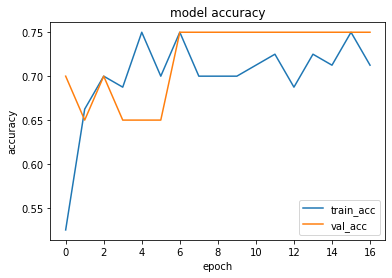

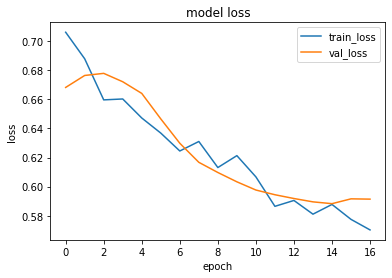

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.61629486]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.5340705]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.16218713]]


1it [00:00, 16710.37it/s]


prediction for video control_1.mov is [[0.08594212]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.76340437]]


1it [00:00, 17331.83it/s]


prediction for video control_3.mov is [[0.17381394]]
Epoch 1/75
3/3 [==============================] - 1s 279ms/step - loss: 0.6738 - accuracy: 0.5375 - precision_86: 0.5211 - recall_86: 0.9250 - val_loss: 0.6706 - val_accuracy: 0.5000 - val_precision_86: 0.5000 - val_recall_86: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6657 - accuracy: 0.5250 - precision_86: 0.5139 - recall_86: 0.9250 - val_loss: 0.6600 - val_accuracy: 0.7500 - val_precision_86: 0.6923 - val_recall_86: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6621 - accuracy: 0.6250 - precision_86: 0.5926 - recall_86: 0.8000 - val_loss: 0.6485 - val_accuracy: 0.8000 - val_precision_86: 0.7500 - val_recall_86: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6377 - accuracy: 0.6250 - precision_86: 0.5926 - recall_86: 0.8000 - val_loss: 0.6376 - val_accuracy: 0.8500 - val_precision_86: 0.8182 - val_recall_86: 0.9000
Epoch 5/75


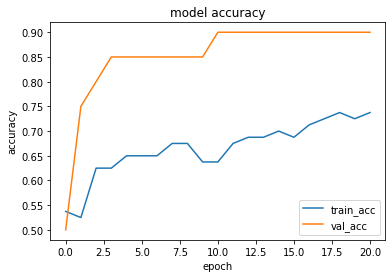

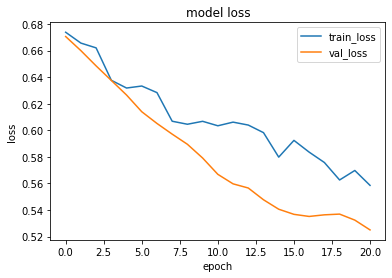

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.41560608]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.5572039]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.32490999]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.15090784]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.81572974]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.2699002]]


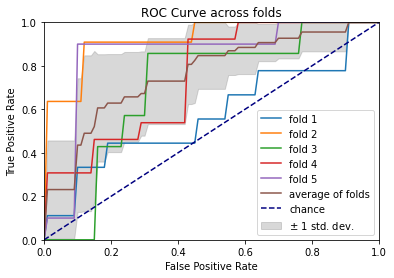

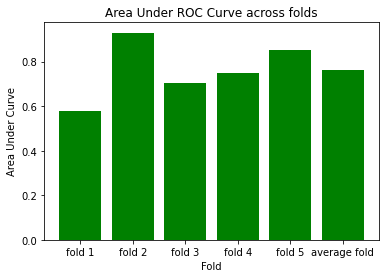

Epoch 1/75
3/3 [==============================] - 1s 257ms/step - loss: 0.7037 - accuracy: 0.3625 - precision_88: 0.3864 - recall_88: 0.4146 - val_loss: 0.6964 - val_accuracy: 0.3500 - val_precision_88: 0.3571 - val_recall_88: 0.5556
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6770 - accuracy: 0.5125 - precision_88: 0.5167 - recall_88: 0.7561 - val_loss: 0.6933 - val_accuracy: 0.4500 - val_precision_88: 0.4444 - val_recall_88: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6907 - accuracy: 0.4750 - precision_88: 0.4921 - recall_88: 0.7561 - val_loss: 0.6921 - val_accuracy: 0.4500 - val_precision_88: 0.4444 - val_recall_88: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6543 - accuracy: 0.5750 - precision_88: 0.5493 - recall_88: 0.9512 - val_loss: 0.6928 - val_accuracy: 0.4000 - val_precision_88: 0.4118 - val_recall_88: 0.7778
Epoch 5/75
3/3 [==============================] - 0s 156ms/step 

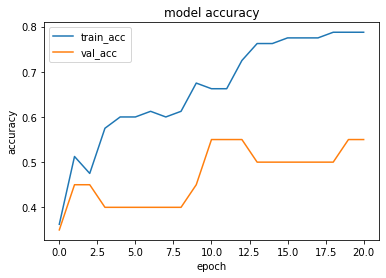

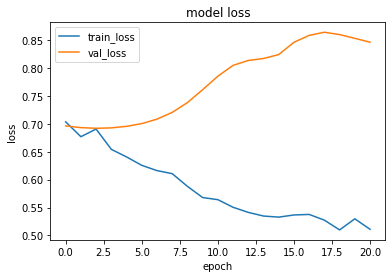

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.3532141]]


1it [00:00, 20068.44it/s]


prediction for video armflapping_3.mov is [[0.6478693]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.21690679]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.09423444]]


1it [00:00, 4544.21it/s]


prediction for video control_2.mov is [[0.85951155]]


1it [00:00, 13662.23it/s]


prediction for video control_3.mov is [[0.13853773]]
Epoch 1/75
3/3 [==============================] - 1s 246ms/step - loss: 0.7200 - accuracy: 0.4000 - precision_89: 0.4000 - recall_89: 0.4615 - val_loss: 0.6873 - val_accuracy: 0.5000 - val_precision_89: 0.5455 - val_recall_89: 0.5455
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6868 - accuracy: 0.6125 - precision_89: 0.6000 - recall_89: 0.6154 - val_loss: 0.6639 - val_accuracy: 0.7500 - val_precision_89: 0.6875 - val_recall_89: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6789 - accuracy: 0.6250 - precision_89: 0.6000 - recall_89: 0.6923 - val_loss: 0.6421 - val_accuracy: 0.7000 - val_precision_89: 0.6471 - val_recall_89: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6704 - accuracy: 0.7000 - precision_89: 0.6531 - recall_89: 0.8205 - val_loss: 0.6249 - val_accuracy: 0.7000 - val_precision_89: 0.6471 - val_recall_89: 1.0000
Epoch 5/75


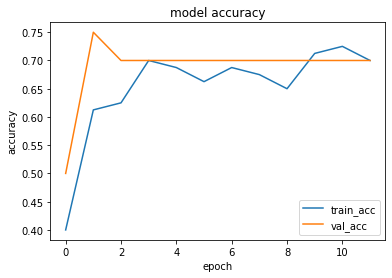

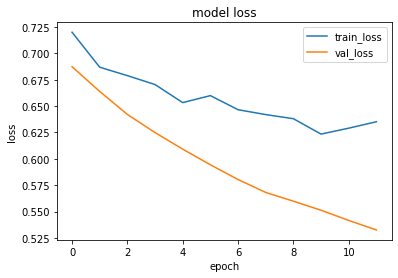

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.50429755]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5152229]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.48547727]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.4346199]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.5474543]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.4477302]]
Epoch 1/75
3/3 [==============================] - 1s 247ms/step - loss: 0.6776 - accuracy: 0.5250 - precision_90: 0.5424 - recall_90: 0.7442 - val_loss: 0.6952 - val_accuracy: 0.4500 - val_precision_90: 0.3889 - val_recall_90: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6655 - accuracy: 0.5500 - precision_90: 0.5467 - recall_90: 0.9535 - val_loss: 0.6908 - val_accuracy: 0.5000 - val_precision_90: 0.4118 - val_recall_90: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6485 - accuracy: 0.5875 - precision_90: 0.5658 - recall_90: 1.0000 - val_loss: 0.6900 - val_accuracy: 0.5000 - val_precision_90: 0.4118 - val_recall_90: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6484 - accuracy: 0.5625 - precision_90: 0.5526 - recall_90: 0.9767 - val_loss: 0.6814 - val_accuracy: 0.5000 - val_precision_90: 0.4118 - val_recall_90: 1.0000
Epoch 5/75
3

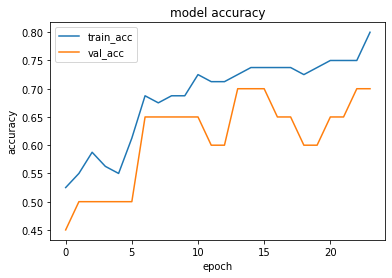

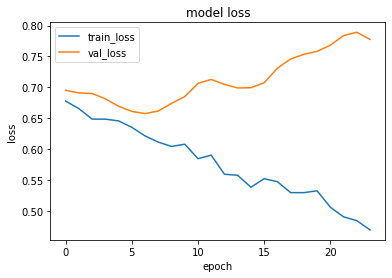

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.44005588]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_3.mov is [[0.62316453]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.23808745]]


1it [00:00, 16320.25it/s]


prediction for video control_1.mov is [[0.13255203]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.9461246]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.3609028]]
Epoch 1/75
3/3 [==============================] - 1s 241ms/step - loss: 0.6958 - accuracy: 0.5250 - precision_91: 0.4815 - recall_91: 0.3514 - val_loss: 0.6898 - val_accuracy: 0.5500 - val_precision_91: 0.7500 - val_recall_91: 0.4615
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6647 - accuracy: 0.7125 - precision_91: 0.7188 - recall_91: 0.6216 - val_loss: 0.6781 - val_accuracy: 0.7500 - val_precision_91: 0.8333 - val_recall_91: 0.7692
Epoch 3/75
3/3 [==============================] - 1s 266ms/step - loss: 0.6644 - accuracy: 0.7000 - precision_91: 0.6585 - recall_91: 0.7297 - val_loss: 0.6709 - val_accuracy: 0.7000 - val_precision_91: 0.7692 - val_recall_91: 0.7692
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6617 - accuracy: 0.7125 - precision_91: 0.6667 - recall_91: 0.7568 - val_loss: 0.6637 - val_accuracy: 0.7000 - val_precision_91: 0.7692 - val_recall_91: 0.7692
Epoch 5/75
3

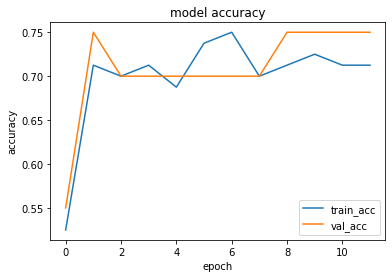

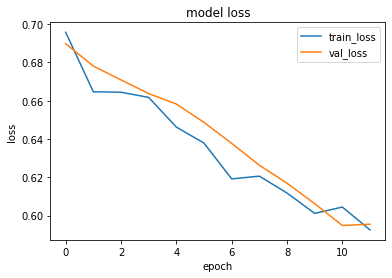

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.6504698]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.56467456]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.3127197]]


1it [00:00, 17331.83it/s]


prediction for video control_1.mov is [[0.09293729]]


1it [00:00, 17331.83it/s]


prediction for video control_2.mov is [[0.81185985]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.30152273]]
Epoch 1/75
3/3 [==============================] - 1s 254ms/step - loss: 0.7089 - accuracy: 0.4750 - precision_92: 0.4821 - recall_92: 0.6750 - val_loss: 0.6829 - val_accuracy: 0.4000 - val_precision_92: 0.4375 - val_recall_92: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6668 - accuracy: 0.6125 - precision_92: 0.5692 - recall_92: 0.9250 - val_loss: 0.6713 - val_accuracy: 0.5500 - val_precision_92: 0.5263 - val_recall_92: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6562 - accuracy: 0.5125 - precision_92: 0.5075 - recall_92: 0.8500 - val_loss: 0.6597 - val_accuracy: 0.6500 - val_precision_92: 0.5882 - val_recall_92: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6498 - accuracy: 0.5875 - precision_92: 0.5522 - recall_92: 0.9250 - val_loss: 0.6488 - val_accuracy: 0.6500 - val_precision_92: 0.5882 - val_recall_92: 1.0000
Epoch 5/75


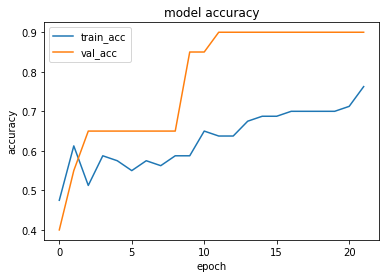

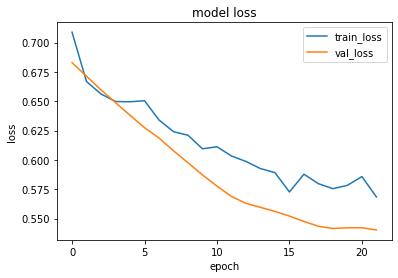

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.4115788]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.54919225]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.31876314]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.1624611]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.80684006]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.24941939]]


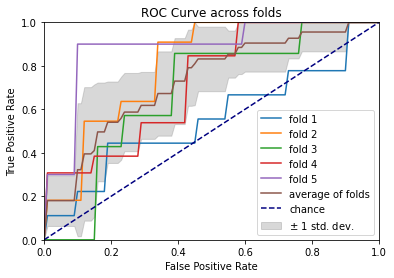

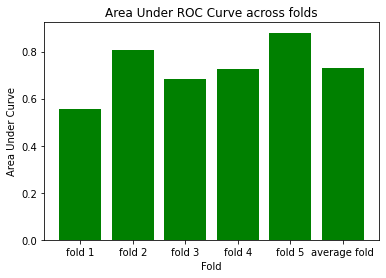

Epoch 1/75
3/3 [==============================] - 1s 237ms/step - loss: 0.6991 - accuracy: 0.4500 - precision_94: 0.3333 - recall_94: 0.0732 - val_loss: 0.7025 - val_accuracy: 0.3500 - val_precision_94: 0.3000 - val_recall_94: 0.3333
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6859 - accuracy: 0.4000 - precision_94: 0.4146 - recall_94: 0.4146 - val_loss: 0.6917 - val_accuracy: 0.5000 - val_precision_94: 0.4667 - val_recall_94: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6627 - accuracy: 0.5875 - precision_94: 0.5571 - recall_94: 0.9512 - val_loss: 0.6880 - val_accuracy: 0.4000 - val_precision_94: 0.4118 - val_recall_94: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6438 - accuracy: 0.5750 - precision_94: 0.5479 - recall_94: 0.9756 - val_loss: 0.6881 - val_accuracy: 0.4000 - val_precision_94: 0.4118 - val_recall_94: 0.7778
Epoch 5/75
3/3 [==============================] - 0s 153ms/step 

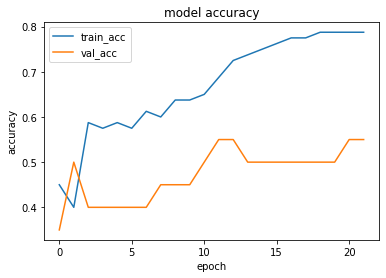

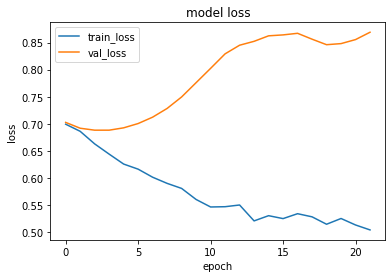

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.18422437]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.6161599]]


1it [00:00, 6853.44it/s]


prediction for video armflapping_2.mov is [[0.10442787]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.04550886]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.87919796]]


1it [00:00, 12633.45it/s]


prediction for video control_3.mov is [[0.06821379]]
Epoch 1/75
3/3 [==============================] - 1s 245ms/step - loss: 0.7192 - accuracy: 0.3875 - precision_95: 0.2222 - recall_95: 0.1026 - val_loss: 0.6987 - val_accuracy: 0.3500 - val_precision_95: 0.0000e+00 - val_recall_95: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6951 - accuracy: 0.3750 - precision_95: 0.3590 - recall_95: 0.3590 - val_loss: 0.6652 - val_accuracy: 0.6000 - val_precision_95: 0.6000 - val_recall_95: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6838 - accuracy: 0.4625 - precision_95: 0.4677 - recall_95: 0.7436 - val_loss: 0.6432 - val_accuracy: 0.6500 - val_precision_95: 0.6111 - val_recall_95: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6657 - accuracy: 0.5250 - precision_95: 0.5068 - recall_95: 0.9487 - val_loss: 0.6257 - val_accuracy: 0.6500 - val_precision_95: 0.6111 - val_recall_95: 1.0000
Epo

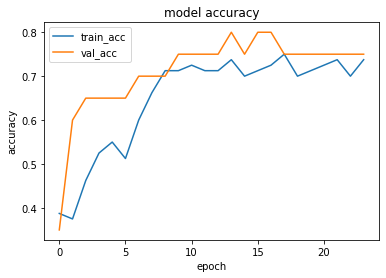

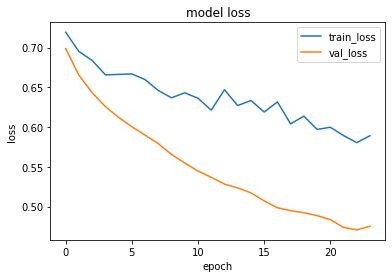

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.37991485]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.52685726]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.3554242]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.15606055]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.7374346]]


1it [00:00, 12985.46it/s]


prediction for video control_3.mov is [[0.28479382]]
Epoch 1/75
3/3 [==============================] - 1s 262ms/step - loss: 0.6979 - accuracy: 0.4125 - precision_96: 0.4630 - recall_96: 0.5814 - val_loss: 0.7120 - val_accuracy: 0.3500 - val_precision_96: 0.3500 - val_recall_96: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6859 - accuracy: 0.5250 - precision_96: 0.5325 - recall_96: 0.9535 - val_loss: 0.7216 - val_accuracy: 0.3500 - val_precision_96: 0.3500 - val_recall_96: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6600 - accuracy: 0.5375 - precision_96: 0.5385 - recall_96: 0.9767 - val_loss: 0.7133 - val_accuracy: 0.3500 - val_precision_96: 0.3500 - val_recall_96: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6588 - accuracy: 0.5375 - precision_96: 0.5375 - recall_96: 1.0000 - val_loss: 0.7099 - val_accuracy: 0.4500 - val_precision_96: 0.3889 - val_recall_96: 1.0000
Epoch 5/75


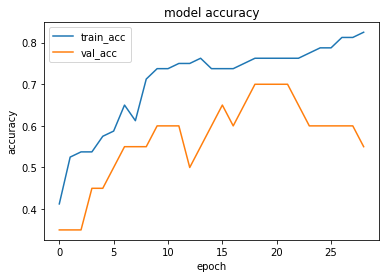

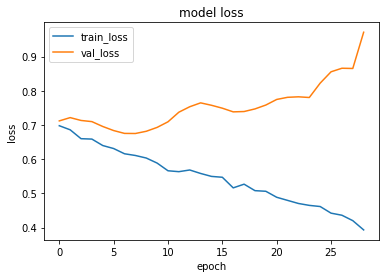

1it [00:00, 17623.13it/s]


prediction for video armflapping_1.mov is [[0.67914486]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.69179595]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.9146906]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.10020888]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.9686111]]


1it [00:00, 16844.59it/s]


prediction for video control_3.mov is [[0.4777899]]
Epoch 1/75
3/3 [==============================] - 1s 268ms/step - loss: 0.6905 - accuracy: 0.4250 - precision_97: 0.3200 - recall_97: 0.2162 - val_loss: 0.7007 - val_accuracy: 0.5000 - val_precision_97: 0.7143 - val_recall_97: 0.3846
Epoch 2/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6656 - accuracy: 0.5500 - precision_97: 0.5116 - recall_97: 0.5946 - val_loss: 0.6734 - val_accuracy: 0.6500 - val_precision_97: 0.7500 - val_recall_97: 0.6923
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6478 - accuracy: 0.6875 - precision_97: 0.6250 - recall_97: 0.8108 - val_loss: 0.6545 - val_accuracy: 0.7500 - val_precision_97: 0.7857 - val_recall_97: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6577 - accuracy: 0.7000 - precision_97: 0.6383 - recall_97: 0.8108 - val_loss: 0.6456 - val_accuracy: 0.7500 - val_precision_97: 0.7857 - val_recall_97: 0.8462
Epoch 5/75
3

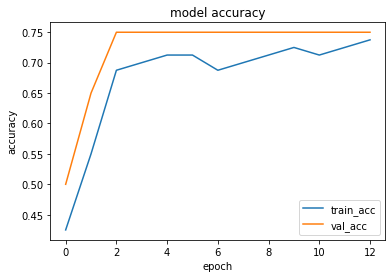

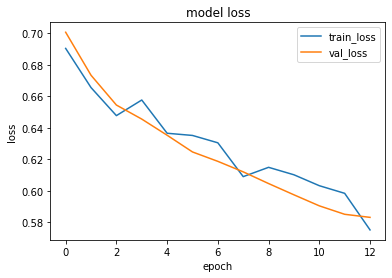

1it [00:00, 20460.02it/s]


prediction for video armflapping_1.mov is [[0.39060363]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_3.mov is [[0.5647145]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.31190717]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.08632773]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.7651618]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.23557225]]
Epoch 1/75
3/3 [==============================] - 1s 263ms/step - loss: 0.7044 - accuracy: 0.3875 - precision_98: 0.3200 - recall_98: 0.2000 - val_loss: 0.6860 - val_accuracy: 0.6500 - val_precision_98: 0.6667 - val_recall_98: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6976 - accuracy: 0.4375 - precision_98: 0.4490 - recall_98: 0.5500 - val_loss: 0.6719 - val_accuracy: 0.5500 - val_precision_98: 0.5263 - val_recall_98: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6710 - accuracy: 0.5375 - precision_98: 0.5217 - recall_98: 0.9000 - val_loss: 0.6611 - val_accuracy: 0.5000 - val_precision_98: 0.5000 - val_recall_98: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6573 - accuracy: 0.5500 - precision_98: 0.5286 - recall_98: 0.9250 - val_loss: 0.6529 - val_accuracy: 0.7000 - val_precision_98: 0.6429 - val_recall_98: 0.9000
Epoch 5/75


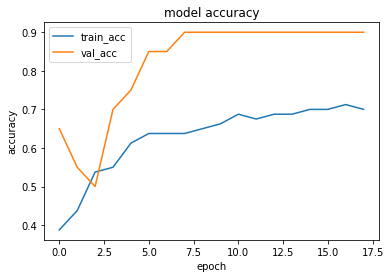

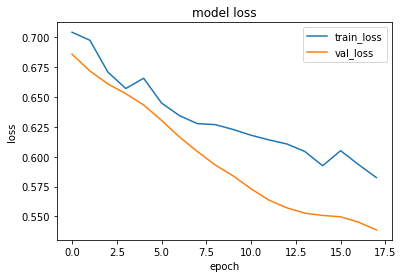

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.46168363]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.5562429]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.37238514]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.19295809]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.72427016]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.3013351]]


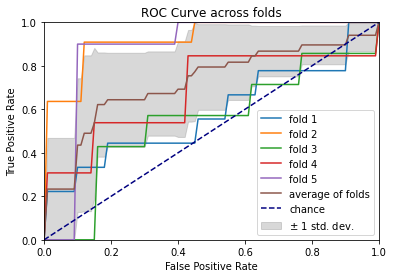

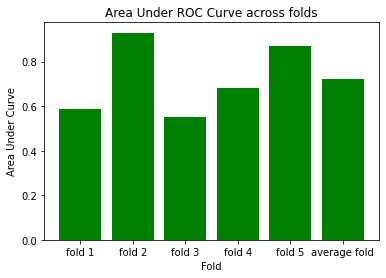

Epoch 1/75
3/3 [==============================] - 1s 246ms/step - loss: 0.6854 - accuracy: 0.4250 - precision_100: 0.4603 - recall_100: 0.7073 - val_loss: 0.6854 - val_accuracy: 0.4500 - val_precision_100: 0.4444 - val_recall_100: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6656 - accuracy: 0.5625 - precision_100: 0.5429 - recall_100: 0.9268 - val_loss: 0.6850 - val_accuracy: 0.4500 - val_precision_100: 0.4444 - val_recall_100: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6539 - accuracy: 0.5750 - precision_100: 0.5467 - recall_100: 1.0000 - val_loss: 0.6861 - val_accuracy: 0.4500 - val_precision_100: 0.4444 - val_recall_100: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6166 - accuracy: 0.6000 - precision_100: 0.5652 - recall_100: 0.9512 - val_loss: 0.6895 - val_accuracy: 0.5000 - val_precision_100: 0.4615 - val_recall_100: 0.6667
Epoch 5/75
3/3 [==============================] 

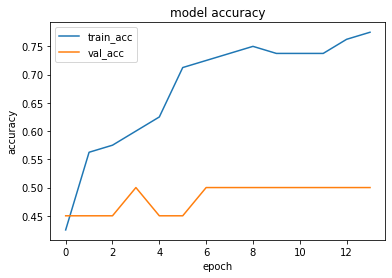

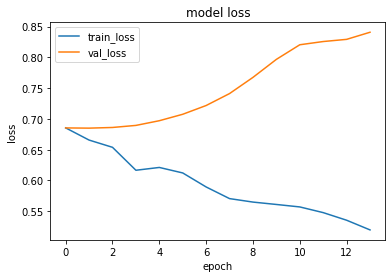

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.5000464]]


1it [00:00, 19152.07it/s]


prediction for video armflapping_3.mov is [[0.5348261]]


1it [00:00, 9157.87it/s]


prediction for video armflapping_2.mov is [[0.40780184]]


1it [00:00, 17331.83it/s]


prediction for video control_1.mov is [[0.26925316]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.68796426]]


1it [00:00, 12052.60it/s]


prediction for video control_3.mov is [[0.31478113]]
Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.7419 - accuracy: 0.3375 - precision_101: 0.2500 - recall_101: 0.1795 - val_loss: 0.7552 - val_accuracy: 0.3500 - val_precision_101: 0.2500 - val_recall_101: 0.0909
Epoch 2/75
3/3 [==============================] - 0s 176ms/step - loss: 0.7068 - accuracy: 0.3250 - precision_101: 0.2857 - recall_101: 0.2564 - val_loss: 0.7212 - val_accuracy: 0.3000 - val_precision_101: 0.2857 - val_recall_101: 0.1818
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6943 - accuracy: 0.4625 - precision_101: 0.4600 - recall_101: 0.5897 - val_loss: 0.6936 - val_accuracy: 0.4500 - val_precision_101: 0.5000 - val_recall_101: 0.5455
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6895 - accuracy: 0.4875 - precision_101: 0.4844 - recall_101: 0.7949 - val_loss: 0.6723 - val_accuracy: 0.6000 - val_precision_101: 0.5789 - val_recall_101: 1.

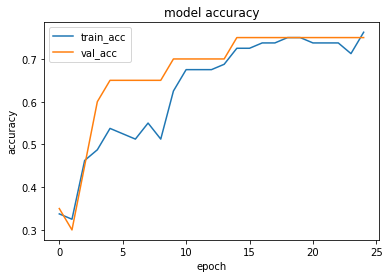

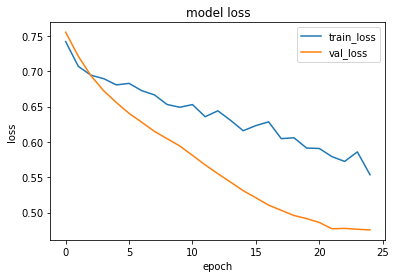

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.5252652]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.5760903]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.44148394]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.17074454]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.7025884]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.33464712]]
Epoch 1/75
3/3 [==============================] - 1s 230ms/step - loss: 0.6759 - accuracy: 0.6875 - precision_102: 0.6957 - recall_102: 0.7442 - val_loss: 0.6990 - val_accuracy: 0.3500 - val_precision_102: 0.3500 - val_recall_102: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6589 - accuracy: 0.6375 - precision_102: 0.6167 - recall_102: 0.8605 - val_loss: 0.6872 - val_accuracy: 0.4500 - val_precision_102: 0.3889 - val_recall_102: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6616 - accuracy: 0.5750 - precision_102: 0.5634 - recall_102: 0.9302 - val_loss: 0.6846 - val_accuracy: 0.4500 - val_precision_102: 0.3889 - val_recall_102: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6412 - accuracy: 0.6375 - precision_102: 0.6000 - recall_102: 0.9767 - val_loss: 0.6864 - val_accuracy: 0.4500 - val_precision_102: 0.3889 - val_recall_102: 1.

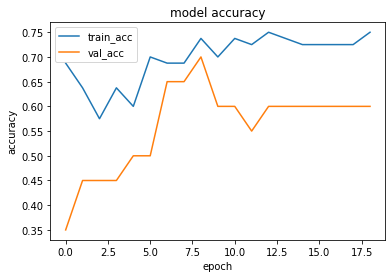

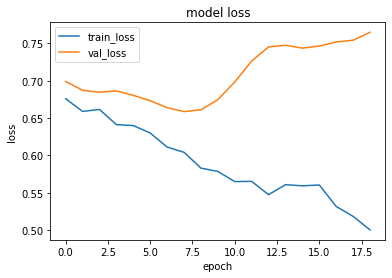

1it [00:00, 19239.93it/s]


prediction for video armflapping_1.mov is [[0.18544543]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.6431005]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.16349024]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.17293]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.91627955]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.17569557]]
Epoch 1/75
3/3 [==============================] - 1s 220ms/step - loss: 0.7082 - accuracy: 0.5250 - precision_103: 0.4828 - recall_103: 0.3784 - val_loss: 0.6886 - val_accuracy: 0.6000 - val_precision_103: 0.8571 - val_recall_103: 0.4615
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6713 - accuracy: 0.6750 - precision_103: 0.8235 - recall_103: 0.3784 - val_loss: 0.6878 - val_accuracy: 0.5500 - val_precision_103: 0.8333 - val_recall_103: 0.3846
Epoch 3/75
3/3 [==============================] - 1s 129ms/step - loss: 0.6678 - accuracy: 0.6000 - precision_103: 0.6087 - recall_103: 0.3784 - val_loss: 0.6790 - val_accuracy: 0.5000 - val_precision_103: 0.7143 - val_recall_103: 0.3846
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6412 - accuracy: 0.7750 - precision_103: 0.8519 - recall_103: 0.6216 - val_loss: 0.6705 - val_accuracy: 0.7000 - val_precision_103: 0.7692 - val_recall_103: 0.

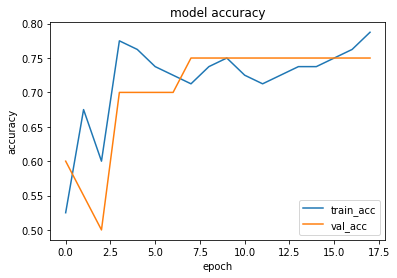

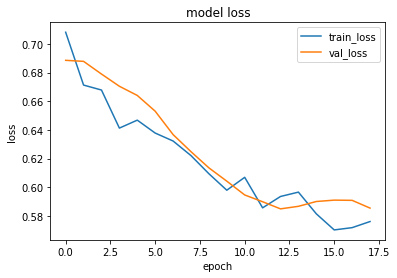

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.4999571]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.516032]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.28556502]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.06965336]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.7910987]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.48882616]]
Epoch 1/75
3/3 [==============================] - 1s 237ms/step - loss: 0.7013 - accuracy: 0.6125 - precision_104: 0.5957 - recall_104: 0.7000 - val_loss: 0.6773 - val_accuracy: 0.8000 - val_precision_104: 0.7500 - val_recall_104: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6874 - accuracy: 0.7125 - precision_104: 0.6889 - recall_104: 0.7750 - val_loss: 0.6666 - val_accuracy: 0.8000 - val_precision_104: 0.7500 - val_recall_104: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6597 - accuracy: 0.6875 - precision_104: 0.6531 - recall_104: 0.8000 - val_loss: 0.6570 - val_accuracy: 0.8000 - val_precision_104: 0.7500 - val_recall_104: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6516 - accuracy: 0.7250 - precision_104: 0.6957 - recall_104: 0.8000 - val_loss: 0.6483 - val_accuracy: 0.9000 - val_precision_104: 0.9000 - val_recall_104: 0.

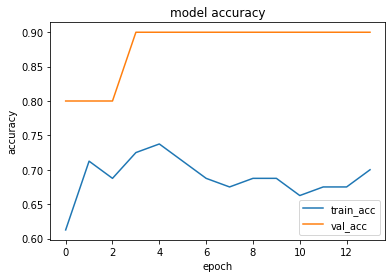

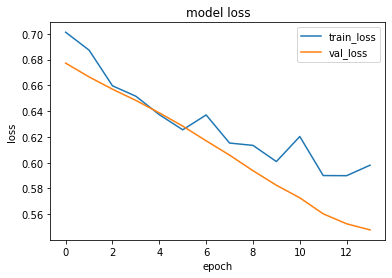

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.48471308]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.5070399]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.45679286]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.36716825]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.61666185]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.385131]]


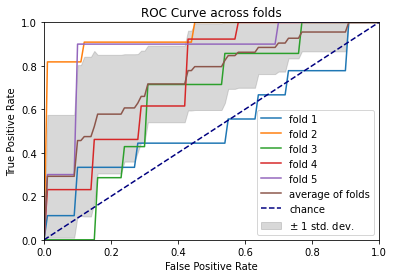

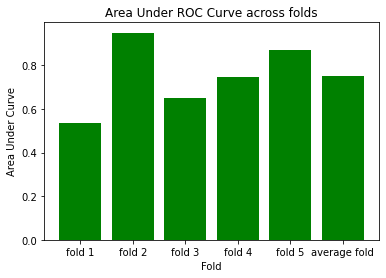

Epoch 1/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6989 - accuracy: 0.5125 - precision_106: 0.5132 - recall_106: 0.9512 - val_loss: 0.6962 - val_accuracy: 0.4500 - val_precision_106: 0.4500 - val_recall_106: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7013 - accuracy: 0.5750 - precision_106: 0.5538 - recall_106: 0.8780 - val_loss: 0.6863 - val_accuracy: 0.5000 - val_precision_106: 0.4615 - val_recall_106: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6558 - accuracy: 0.7000 - precision_106: 0.6545 - recall_106: 0.8780 - val_loss: 0.6826 - val_accuracy: 0.5000 - val_precision_106: 0.4545 - val_recall_106: 0.5556
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6549 - accuracy: 0.7250 - precision_106: 0.6667 - recall_106: 0.9268 - val_loss: 0.6811 - val_accuracy: 0.5000 - val_precision_106: 0.4545 - val_recall_106: 0.5556
Epoch 5/75
3/3 [==============================] 

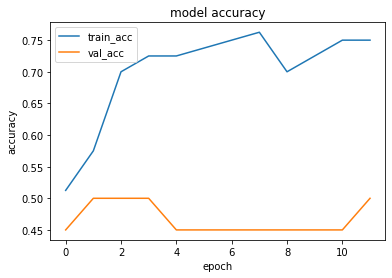

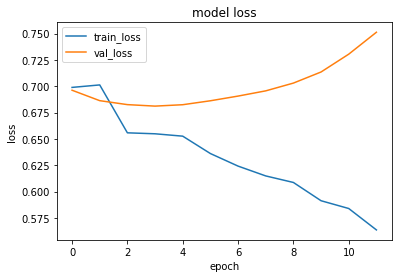

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.5754267]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.50932515]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.5796334]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.5427201]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.578825]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.55869734]]
Epoch 1/75
3/3 [==============================] - 1s 211ms/step - loss: 0.6956 - accuracy: 0.5125 - precision_107: 0.5000 - recall_107: 0.9744 - val_loss: 0.6588 - val_accuracy: 0.6500 - val_precision_107: 0.6111 - val_recall_107: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 175ms/step - loss: 0.6826 - accuracy: 0.6125 - precision_107: 0.5741 - recall_107: 0.7949 - val_loss: 0.6406 - val_accuracy: 0.7000 - val_precision_107: 0.6471 - val_recall_107: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6665 - accuracy: 0.7000 - precision_107: 0.6596 - recall_107: 0.7949 - val_loss: 0.6239 - val_accuracy: 0.7000 - val_precision_107: 0.6471 - val_recall_107: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6579 - accuracy: 0.6875 - precision_107: 0.6522 - recall_107: 0.7692 - val_loss: 0.6095 - val_accuracy: 0.7000 - val_precision_107: 0.6471 - val_recall_107: 1.

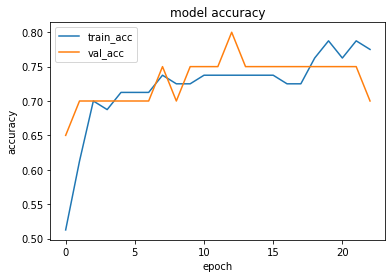

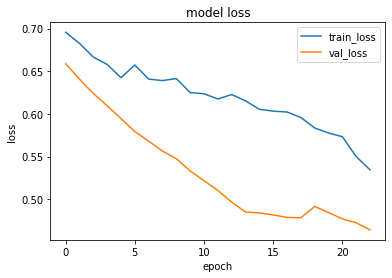

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.30272228]]


1it [00:00, 16320.25it/s]


prediction for video armflapping_3.mov is [[0.5601936]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.22711891]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.10454798]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.7655914]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.18389878]]
Epoch 1/75
3/3 [==============================] - 1s 221ms/step - loss: 0.6771 - accuracy: 0.5500 - precision_108: 0.5479 - recall_108: 0.9302 - val_loss: 0.7267 - val_accuracy: 0.3500 - val_precision_108: 0.3500 - val_recall_108: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6740 - accuracy: 0.5375 - precision_108: 0.5375 - recall_108: 1.0000 - val_loss: 0.7180 - val_accuracy: 0.3500 - val_precision_108: 0.3500 - val_recall_108: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6467 - accuracy: 0.5875 - precision_108: 0.5658 - recall_108: 1.0000 - val_loss: 0.7061 - val_accuracy: 0.5000 - val_precision_108: 0.4118 - val_recall_108: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6397 - accuracy: 0.6375 - precision_108: 0.6094 - recall_108: 0.9070 - val_loss: 0.6920 - val_accuracy: 0.5000 - val_precision_108: 0.4118 - val_recall_108: 1.

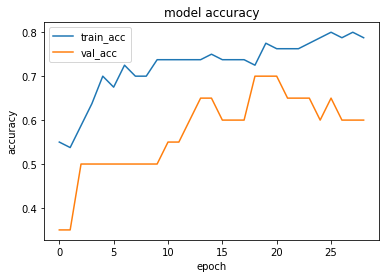

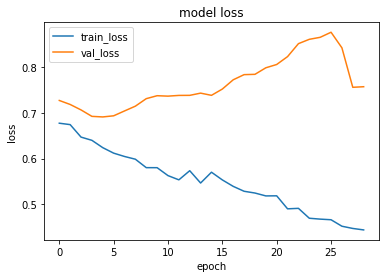

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.61426425]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.5954474]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.4838397]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.14458847]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.924009]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.6064926]]
Epoch 1/75
3/3 [==============================] - 1s 239ms/step - loss: 0.7084 - accuracy: 0.3500 - precision_109: 0.3636 - recall_109: 0.5405 - val_loss: 0.6958 - val_accuracy: 0.5500 - val_precision_109: 0.7500 - val_recall_109: 0.4615
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6772 - accuracy: 0.5125 - precision_109: 0.4792 - recall_109: 0.6216 - val_loss: 0.6859 - val_accuracy: 0.6500 - val_precision_109: 0.8750 - val_recall_109: 0.5385
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6825 - accuracy: 0.6000 - precision_109: 0.5581 - recall_109: 0.6486 - val_loss: 0.6789 - val_accuracy: 0.7000 - val_precision_109: 0.8182 - val_recall_109: 0.6923
Epoch 4/75
3/3 [==============================] - 1s 231ms/step - loss: 0.6507 - accuracy: 0.6500 - precision_109: 0.6047 - recall_109: 0.7027 - val_loss: 0.6676 - val_accuracy: 0.7000 - val_precision_109: 0.8182 - val_recall_109: 0.6

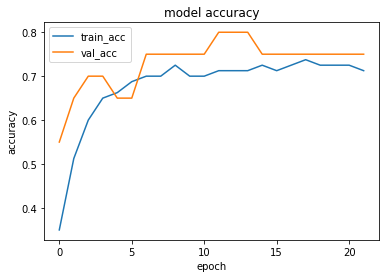

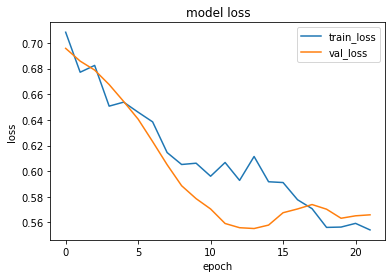

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.6909211]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.585232]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.44365022]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.0715656]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.8273505]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.48599982]]
Epoch 1/75
3/3 [==============================] - 1s 228ms/step - loss: 0.7036 - accuracy: 0.5125 - precision_110: 0.5152 - recall_110: 0.4250 - val_loss: 0.6836 - val_accuracy: 0.6500 - val_precision_110: 0.6667 - val_recall_110: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6753 - accuracy: 0.5750 - precision_110: 0.5652 - recall_110: 0.6500 - val_loss: 0.6754 - val_accuracy: 0.8000 - val_precision_110: 0.8750 - val_recall_110: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6670 - accuracy: 0.6625 - precision_110: 0.6585 - recall_110: 0.6750 - val_loss: 0.6677 - val_accuracy: 0.8000 - val_precision_110: 0.8750 - val_recall_110: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6540 - accuracy: 0.7500 - precision_110: 0.7632 - recall_110: 0.7250 - val_loss: 0.6593 - val_accuracy: 0.9000 - val_precision_110: 0.9000 - val_recall_110: 0.

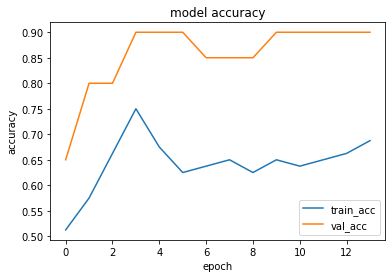

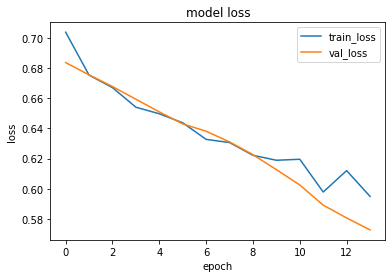

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.4966526]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.50144565]]


1it [00:00, 8004.40it/s]


prediction for video armflapping_2.mov is [[0.41626847]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.30744198]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.5945959]]


1it [00:00, 8542.37it/s]


prediction for video control_3.mov is [[0.37976158]]


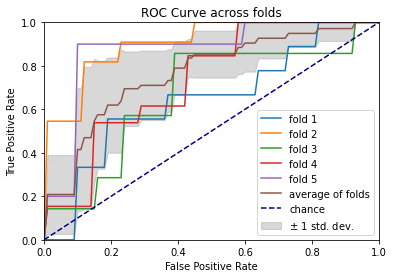

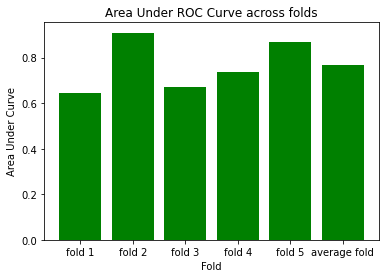

Epoch 1/75
3/3 [==============================] - 1s 261ms/step - loss: 0.7003 - accuracy: 0.5500 - precision_112: 0.5641 - recall_112: 0.5366 - val_loss: 0.6941 - val_accuracy: 0.5500 - val_precision_112: 0.5000 - val_recall_112: 0.5556
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6741 - accuracy: 0.6875 - precision_112: 0.6739 - recall_112: 0.7561 - val_loss: 0.6892 - val_accuracy: 0.5500 - val_precision_112: 0.5000 - val_recall_112: 0.5556
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6608 - accuracy: 0.7250 - precision_112: 0.6792 - recall_112: 0.8780 - val_loss: 0.6866 - val_accuracy: 0.5500 - val_precision_112: 0.5000 - val_recall_112: 0.5556
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6469 - accuracy: 0.7500 - precision_112: 0.6909 - recall_112: 0.9268 - val_loss: 0.6858 - val_accuracy: 0.5000 - val_precision_112: 0.4444 - val_recall_112: 0.4444
Epoch 5/75
3/3 [==============================] 

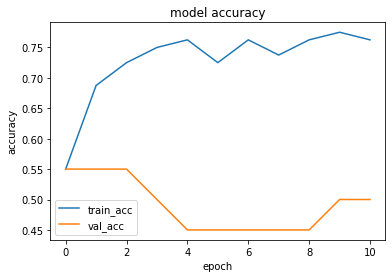

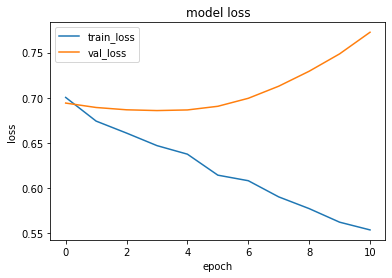

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.52892995]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5105422]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.5347173]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.4923706]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.5232357]]


1it [00:00, 21732.15it/s]


prediction for video control_3.mov is [[0.5357634]]
Epoch 1/75
3/3 [==============================] - 1s 256ms/step - loss: 0.6833 - accuracy: 0.4875 - precision_113: 0.4844 - recall_113: 0.7949 - val_loss: 0.6582 - val_accuracy: 0.6500 - val_precision_113: 0.6111 - val_recall_113: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6821 - accuracy: 0.5625 - precision_113: 0.5345 - recall_113: 0.7949 - val_loss: 0.6476 - val_accuracy: 0.7000 - val_precision_113: 0.6471 - val_recall_113: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6716 - accuracy: 0.6500 - precision_113: 0.6170 - recall_113: 0.7436 - val_loss: 0.6370 - val_accuracy: 0.7000 - val_precision_113: 0.6471 - val_recall_113: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6670 - accuracy: 0.6125 - precision_113: 0.5952 - recall_113: 0.6410 - val_loss: 0.6246 - val_accuracy: 0.7000 - val_precision_113: 0.6471 - val_recall_113: 1.0

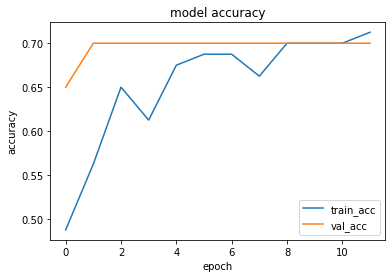

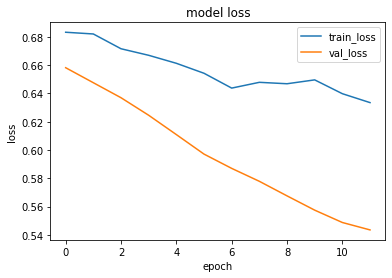

1it [00:00, 18315.74it/s]


prediction for video armflapping_1.mov is [[0.5077782]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.5148903]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.46131426]]


1it [00:00, 16320.25it/s]


prediction for video control_1.mov is [[0.3961551]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.5672919]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.4125327]]
Epoch 1/75
3/3 [==============================] - 1s 264ms/step - loss: 0.6765 - accuracy: 0.5625 - precision_114: 0.5556 - recall_114: 0.9302 - val_loss: 0.7110 - val_accuracy: 0.3500 - val_precision_114: 0.3500 - val_recall_114: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6638 - accuracy: 0.5625 - precision_114: 0.5526 - recall_114: 0.9767 - val_loss: 0.7035 - val_accuracy: 0.4500 - val_precision_114: 0.3889 - val_recall_114: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6520 - accuracy: 0.5625 - precision_114: 0.5526 - recall_114: 0.9767 - val_loss: 0.6860 - val_accuracy: 0.5000 - val_precision_114: 0.4118 - val_recall_114: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 249ms/step - loss: 0.6729 - accuracy: 0.5750 - precision_114: 0.5600 - recall_114: 0.9767 - val_loss: 0.6802 - val_accuracy: 0.5000 - val_precision_114: 0.4118 - val_recall_114: 1.0

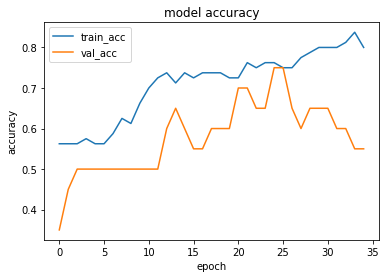

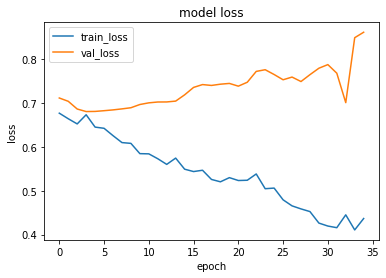

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.210255]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_3.mov is [[0.6562811]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.17030182]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.14709601]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.9287544]]


1it [00:00, 21732.15it/s]


prediction for video control_3.mov is [[0.17883566]]
Epoch 1/75
3/3 [==============================] - 1s 256ms/step - loss: 0.6820 - accuracy: 0.5000 - precision_115: 0.4783 - recall_115: 0.8919 - val_loss: 0.6549 - val_accuracy: 0.7500 - val_precision_115: 0.7857 - val_recall_115: 0.8462
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6743 - accuracy: 0.6500 - precision_115: 0.5849 - recall_115: 0.8378 - val_loss: 0.6698 - val_accuracy: 0.7000 - val_precision_115: 0.7692 - val_recall_115: 0.7692
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6615 - accuracy: 0.6750 - precision_115: 0.6341 - recall_115: 0.7027 - val_loss: 0.6781 - val_accuracy: 0.7000 - val_precision_115: 0.7692 - val_recall_115: 0.7692
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6587 - accuracy: 0.7125 - precision_115: 0.7059 - recall_115: 0.6486 - val_loss: 0.6764 - val_accuracy: 0.6500 - val_precision_115: 0.7500 - val_recall_115: 0.

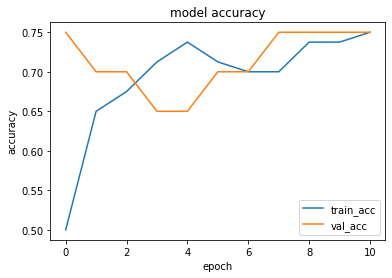

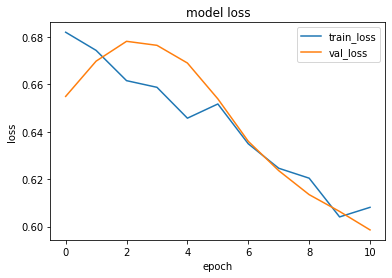

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.42118958]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5432003]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.33283907]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.12142035]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.7394004]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.2323955]]
Epoch 1/75
3/3 [==============================] - 1s 258ms/step - loss: 0.6829 - accuracy: 0.5250 - precision_116: 0.5179 - recall_116: 0.7250 - val_loss: 0.6790 - val_accuracy: 0.5000 - val_precision_116: 0.5000 - val_recall_116: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6710 - accuracy: 0.5875 - precision_116: 0.5507 - recall_116: 0.9500 - val_loss: 0.6718 - val_accuracy: 0.7500 - val_precision_116: 0.6923 - val_recall_116: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6708 - accuracy: 0.6125 - precision_116: 0.5882 - recall_116: 0.7500 - val_loss: 0.6638 - val_accuracy: 0.7500 - val_precision_116: 0.6923 - val_recall_116: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6539 - accuracy: 0.6625 - precision_116: 0.6226 - recall_116: 0.8250 - val_loss: 0.6558 - val_accuracy: 0.8000 - val_precision_116: 0.7500 - val_recall_116: 0.9

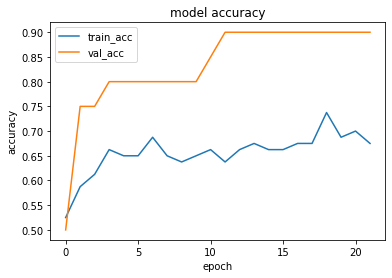

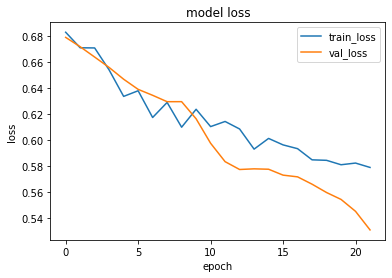

1it [00:00, 6413.31it/s]


prediction for video armflapping_1.mov is [[0.32817438]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.55686206]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.23374292]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.08495441]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.8030901]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.1668337]]


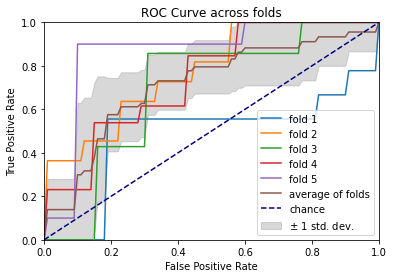

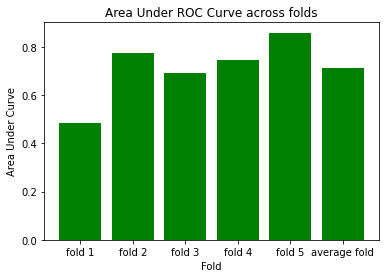

Epoch 1/75
3/3 [==============================] - 1s 277ms/step - loss: 0.6817 - accuracy: 0.5250 - precision_118: 0.5333 - recall_118: 0.5854 - val_loss: 0.6888 - val_accuracy: 0.4000 - val_precision_118: 0.4118 - val_recall_118: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6668 - accuracy: 0.5125 - precision_118: 0.5147 - recall_118: 0.8537 - val_loss: 0.6863 - val_accuracy: 0.4500 - val_precision_118: 0.4444 - val_recall_118: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6477 - accuracy: 0.5500 - precision_118: 0.5352 - recall_118: 0.9268 - val_loss: 0.6859 - val_accuracy: 0.4500 - val_precision_118: 0.4444 - val_recall_118: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 131ms/step - loss: 0.6279 - accuracy: 0.5875 - precision_118: 0.5556 - recall_118: 0.9756 - val_loss: 0.6889 - val_accuracy: 0.4500 - val_precision_118: 0.4444 - val_recall_118: 0.8889
Epoch 5/75
3/3 [==============================] 

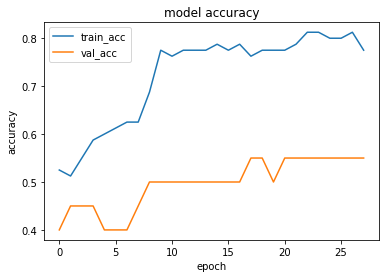

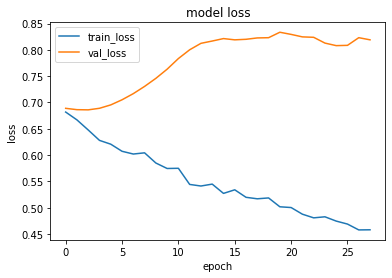

1it [00:00, 12787.51it/s]


prediction for video armflapping_1.mov is [[0.10862675]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5991792]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_2.mov is [[0.05978847]]


1it [00:00, 18808.54it/s]


prediction for video control_1.mov is [[0.02943259]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.897457]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.04072195]]
Epoch 1/75
3/3 [==============================] - 1s 264ms/step - loss: 0.6916 - accuracy: 0.4125 - precision_119: 0.3889 - recall_119: 0.3590 - val_loss: 0.6670 - val_accuracy: 0.7500 - val_precision_119: 0.8000 - val_recall_119: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6806 - accuracy: 0.4500 - precision_119: 0.4490 - recall_119: 0.5641 - val_loss: 0.6387 - val_accuracy: 0.8000 - val_precision_119: 0.8182 - val_recall_119: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6584 - accuracy: 0.5875 - precision_119: 0.5577 - recall_119: 0.7436 - val_loss: 0.6194 - val_accuracy: 0.8000 - val_precision_119: 0.8182 - val_recall_119: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6493 - accuracy: 0.5875 - precision_119: 0.5556 - recall_119: 0.7692 - val_loss: 0.5990 - val_accuracy: 0.8000 - val_precision_119: 0.7692 - val_recall_119: 0.

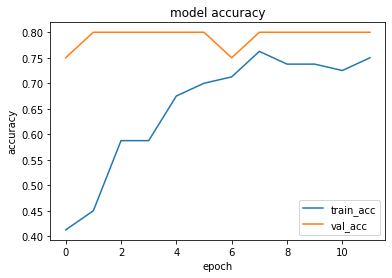

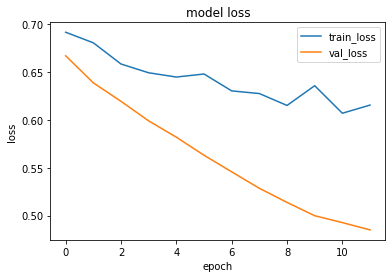

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.5089571]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.4984775]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.47131476]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.37400046]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.55573845]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.44664448]]
Epoch 1/75
3/3 [==============================] - 1s 274ms/step - loss: 0.7048 - accuracy: 0.4250 - precision_120: 0.4595 - recall_120: 0.3953 - val_loss: 0.6959 - val_accuracy: 0.4500 - val_precision_120: 0.3889 - val_recall_120: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6834 - accuracy: 0.5750 - precision_120: 0.5634 - recall_120: 0.9302 - val_loss: 0.6895 - val_accuracy: 0.4500 - val_precision_120: 0.3889 - val_recall_120: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6755 - accuracy: 0.5500 - precision_120: 0.5455 - recall_120: 0.9767 - val_loss: 0.6907 - val_accuracy: 0.4500 - val_precision_120: 0.3889 - val_recall_120: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6629 - accuracy: 0.5625 - precision_120: 0.5513 - recall_120: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.4500 - val_precision_120: 0.3889 - val_recall_120: 1.

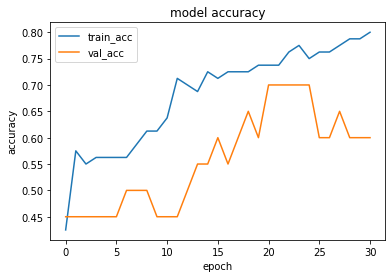

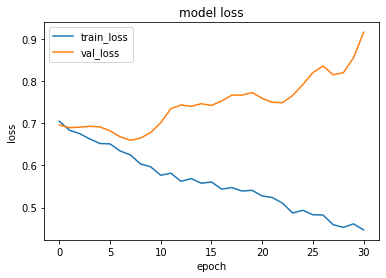

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.3452232]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.7272912]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.3319809]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.14672706]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.9631738]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.546196]]
Epoch 1/75
3/3 [==============================] - 1s 259ms/step - loss: 0.6861 - accuracy: 0.5500 - precision_121: 0.5143 - recall_121: 0.4865 - val_loss: 0.6991 - val_accuracy: 0.6000 - val_precision_121: 0.7273 - val_recall_121: 0.6154
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6748 - accuracy: 0.6750 - precision_121: 0.6667 - recall_121: 0.5946 - val_loss: 0.6828 - val_accuracy: 0.7000 - val_precision_121: 0.7692 - val_recall_121: 0.7692
Epoch 3/75
3/3 [==============================] - 1s 221ms/step - loss: 0.6520 - accuracy: 0.6750 - precision_121: 0.6279 - recall_121: 0.7297 - val_loss: 0.6759 - val_accuracy: 0.7000 - val_precision_121: 0.7692 - val_recall_121: 0.7692
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6330 - accuracy: 0.7000 - precision_121: 0.6667 - recall_121: 0.7027 - val_loss: 0.6652 - val_accuracy: 0.7000 - val_precision_121: 0.7692 - val_recall_121: 0.76

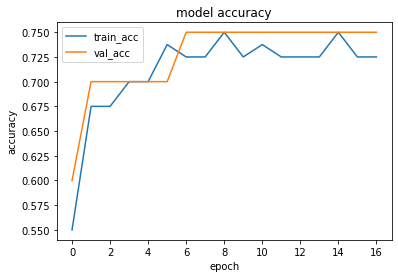

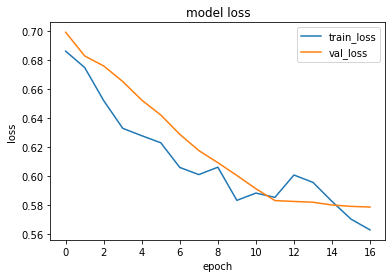

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.35519335]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.54224145]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.2714973]]


1it [00:00, 17331.83it/s]


prediction for video control_1.mov is [[0.09719881]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.7597436]]


1it [00:00, 18315.74it/s]


prediction for video control_3.mov is [[0.21408236]]
Epoch 1/75
3/3 [==============================] - 1s 269ms/step - loss: 0.6957 - accuracy: 0.4125 - precision_122: 0.3704 - recall_122: 0.2500 - val_loss: 0.6850 - val_accuracy: 0.3000 - val_precision_122: 0.3000 - val_recall_122: 0.3000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6880 - accuracy: 0.4125 - precision_122: 0.4286 - recall_122: 0.5250 - val_loss: 0.6751 - val_accuracy: 0.5000 - val_precision_122: 0.5000 - val_recall_122: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6745 - accuracy: 0.5125 - precision_122: 0.5085 - recall_122: 0.7500 - val_loss: 0.6666 - val_accuracy: 0.4500 - val_precision_122: 0.4737 - val_recall_122: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6498 - accuracy: 0.5750 - precision_122: 0.5484 - recall_122: 0.8500 - val_loss: 0.6592 - val_accuracy: 0.5000 - val_precision_122: 0.5000 - val_recall_122: 1.

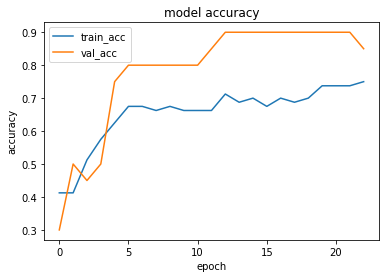

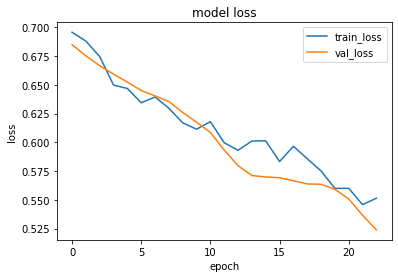

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.3726039]]


1it [00:00, 10010.27it/s]


prediction for video armflapping_3.mov is [[0.54158646]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.22988981]]


1it [00:00, 18315.74it/s]


prediction for video control_1.mov is [[0.11119923]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.7545668]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.16889808]]


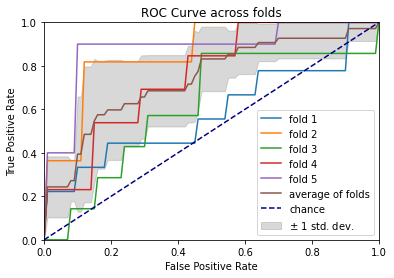

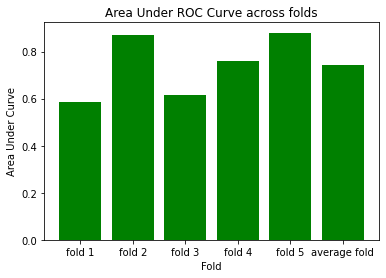

Epoch 1/75
3/3 [==============================] - 1s 279ms/step - loss: 0.7043 - accuracy: 0.4375 - precision_124: 0.4375 - recall_124: 0.3415 - val_loss: 0.6963 - val_accuracy: 0.3500 - val_precision_124: 0.3333 - val_recall_124: 0.4444
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6827 - accuracy: 0.4875 - precision_124: 0.5000 - recall_124: 0.6098 - val_loss: 0.6901 - val_accuracy: 0.4500 - val_precision_124: 0.4444 - val_recall_124: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6524 - accuracy: 0.5500 - precision_124: 0.5373 - recall_124: 0.8780 - val_loss: 0.6869 - val_accuracy: 0.4500 - val_precision_124: 0.4444 - val_recall_124: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6502 - accuracy: 0.6000 - precision_124: 0.5634 - recall_124: 0.9756 - val_loss: 0.6856 - val_accuracy: 0.4500 - val_precision_124: 0.4444 - val_recall_124: 0.8889
Epoch 5/75
3/3 [==============================] 

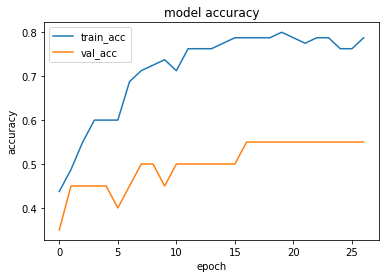

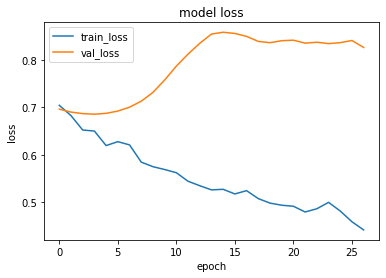

1it [00:00, 17331.83it/s]


prediction for video armflapping_1.mov is [[0.12598076]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.619351]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.07734394]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.0310742]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.8861488]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.04136086]]
Epoch 1/75
3/3 [==============================] - 1s 264ms/step - loss: 0.6822 - accuracy: 0.6500 - precision_125: 0.6170 - recall_125: 0.7436 - val_loss: 0.6373 - val_accuracy: 0.7000 - val_precision_125: 0.6923 - val_recall_125: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6675 - accuracy: 0.6750 - precision_125: 0.6757 - recall_125: 0.6410 - val_loss: 0.6266 - val_accuracy: 0.8000 - val_precision_125: 0.8182 - val_recall_125: 0.8182
Epoch 3/75
3/3 [==============================] - 1s 231ms/step - loss: 0.6589 - accuracy: 0.7000 - precision_125: 0.7273 - recall_125: 0.6154 - val_loss: 0.6177 - val_accuracy: 0.7500 - val_precision_125: 0.8000 - val_recall_125: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6586 - accuracy: 0.7000 - precision_125: 0.7419 - recall_125: 0.5897 - val_loss: 0.6060 - val_accuracy: 0.7000 - val_precision_125: 0.7273 - val_recall_125: 0.

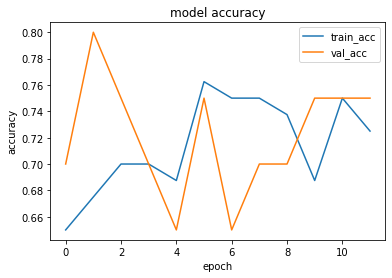

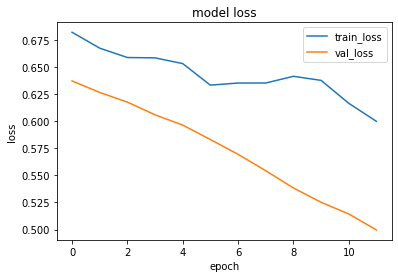

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.5241605]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.48719746]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.44722897]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.44944933]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.61198205]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.4851817]]
Epoch 1/75
3/3 [==============================] - 1s 258ms/step - loss: 0.7019 - accuracy: 0.4500 - precision_126: 0.4889 - recall_126: 0.5116 - val_loss: 0.6795 - val_accuracy: 0.5000 - val_precision_126: 0.4118 - val_recall_126: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6634 - accuracy: 0.5625 - precision_126: 0.5541 - recall_126: 0.9535 - val_loss: 0.6762 - val_accuracy: 0.5000 - val_precision_126: 0.4118 - val_recall_126: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6632 - accuracy: 0.5500 - precision_126: 0.5467 - recall_126: 0.9535 - val_loss: 0.6744 - val_accuracy: 0.5000 - val_precision_126: 0.4118 - val_recall_126: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6527 - accuracy: 0.5500 - precision_126: 0.5455 - recall_126: 0.9767 - val_loss: 0.6756 - val_accuracy: 0.5000 - val_precision_126: 0.4118 - val_recall_126: 1.0

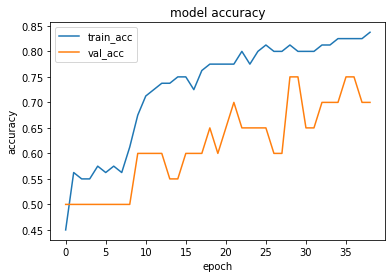

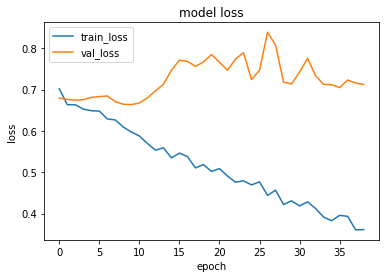

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.9553425]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.6699829]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.9546869]]


1it [00:00, 24244.53it/s]


prediction for video control_1.mov is [[0.09472361]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.96747226]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.974816]]
Epoch 1/75
3/3 [==============================] - 1s 274ms/step - loss: 0.7184 - accuracy: 0.4500 - precision_127: 0.3158 - recall_127: 0.1622 - val_loss: 0.7361 - val_accuracy: 0.3000 - val_precision_127: 0.4444 - val_recall_127: 0.3077
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6917 - accuracy: 0.4375 - precision_127: 0.3462 - recall_127: 0.2432 - val_loss: 0.7113 - val_accuracy: 0.3000 - val_precision_127: 0.4444 - val_recall_127: 0.3077
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6794 - accuracy: 0.4125 - precision_127: 0.3611 - recall_127: 0.3514 - val_loss: 0.6885 - val_accuracy: 0.6000 - val_precision_127: 0.6471 - val_recall_127: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6660 - accuracy: 0.5625 - precision_127: 0.5179 - recall_127: 0.7838 - val_loss: 0.6722 - val_accuracy: 0.7000 - val_precision_127: 0.7692 - val_recall_127: 0.76

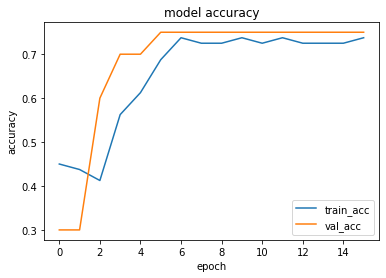

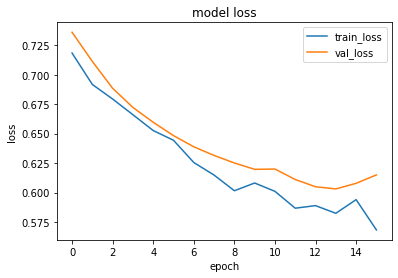

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.6498468]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5775502]]


1it [00:00, 21845.33it/s]


prediction for video armflapping_2.mov is [[0.5691163]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.05906311]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.8161019]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.5388099]]
Epoch 1/75
3/3 [==============================] - 1s 254ms/step - loss: 0.6877 - accuracy: 0.5500 - precision_128: 0.5909 - recall_128: 0.3250 - val_loss: 0.6854 - val_accuracy: 0.6500 - val_precision_128: 0.6667 - val_recall_128: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6882 - accuracy: 0.6250 - precision_128: 0.6316 - recall_128: 0.6000 - val_loss: 0.6766 - val_accuracy: 0.8000 - val_precision_128: 0.7500 - val_recall_128: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6682 - accuracy: 0.6625 - precision_128: 0.6383 - recall_128: 0.7500 - val_loss: 0.6682 - val_accuracy: 0.8000 - val_precision_128: 0.7500 - val_recall_128: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6710 - accuracy: 0.6875 - precision_128: 0.6471 - recall_128: 0.8250 - val_loss: 0.6600 - val_accuracy: 0.8000 - val_precision_128: 0.7500 - val_recall_128: 0.9

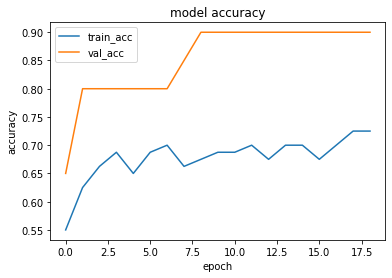

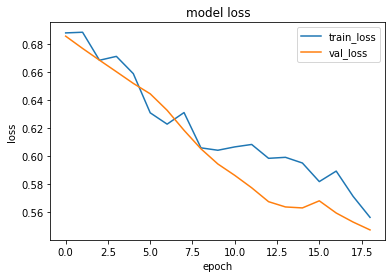

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.50680715]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.5239931]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.34145534]]


1it [00:00, 12985.46it/s]


prediction for video control_1.mov is [[0.19952011]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.7485609]]


1it [00:00, 9258.95it/s]


prediction for video control_3.mov is [[0.29363358]]


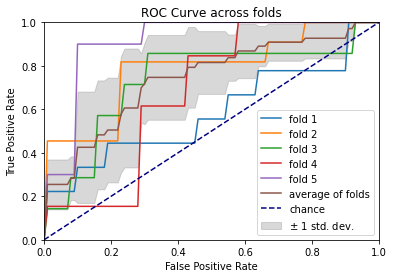

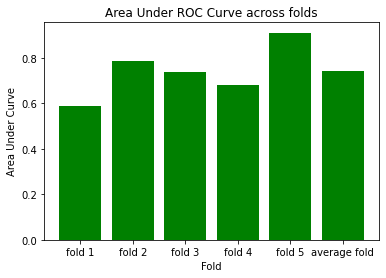

Epoch 1/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6829 - accuracy: 0.6375 - precision_130: 0.6111 - recall_130: 0.8049 - val_loss: 0.6819 - val_accuracy: 0.5000 - val_precision_130: 0.4545 - val_recall_130: 0.5556
Epoch 2/75
3/3 [==============================] - 0s 176ms/step - loss: 0.6595 - accuracy: 0.6875 - precision_130: 0.6538 - recall_130: 0.8293 - val_loss: 0.6798 - val_accuracy: 0.4500 - val_precision_130: 0.4000 - val_recall_130: 0.4444
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6423 - accuracy: 0.6500 - precision_130: 0.6066 - recall_130: 0.9024 - val_loss: 0.6802 - val_accuracy: 0.4500 - val_precision_130: 0.4000 - val_recall_130: 0.4444
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6331 - accuracy: 0.6250 - precision_130: 0.5873 - recall_130: 0.9024 - val_loss: 0.6836 - val_accuracy: 0.4000 - val_precision_130: 0.4118 - val_recall_130: 0.7778
Epoch 5/75
3/3 [==============================] 

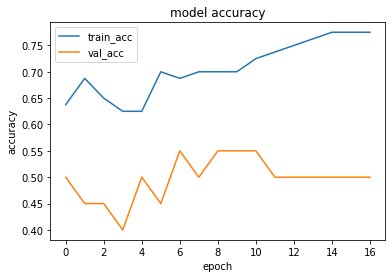

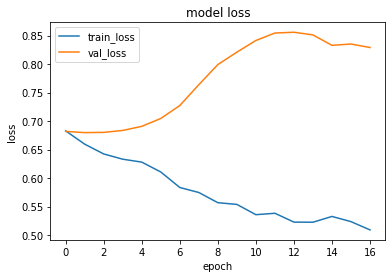

1it [00:00, 17623.13it/s]


prediction for video armflapping_1.mov is [[0.36116207]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.5785188]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.22646242]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.14193046]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.79643893]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.20523408]]
Epoch 1/75
3/3 [==============================] - 1s 245ms/step - loss: 0.7087 - accuracy: 0.4375 - precision_131: 0.4211 - recall_131: 0.4103 - val_loss: 0.6770 - val_accuracy: 0.7500 - val_precision_131: 0.7500 - val_recall_131: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6943 - accuracy: 0.4375 - precision_131: 0.4444 - recall_131: 0.6154 - val_loss: 0.6592 - val_accuracy: 0.7000 - val_precision_131: 0.6667 - val_recall_131: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6777 - accuracy: 0.6250 - precision_131: 0.6047 - recall_131: 0.6667 - val_loss: 0.6429 - val_accuracy: 0.7000 - val_precision_131: 0.6667 - val_recall_131: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6661 - accuracy: 0.6875 - precision_131: 0.6750 - recall_131: 0.6923 - val_loss: 0.6247 - val_accuracy: 0.7500 - val_precision_131: 0.6875 - val_recall_131: 1.

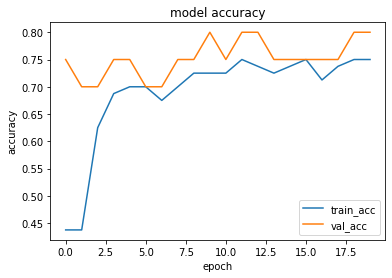

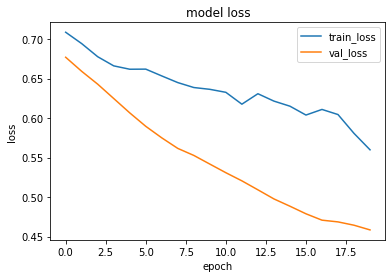

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.41845596]]


1it [00:00, 21732.15it/s]


prediction for video armflapping_3.mov is [[0.52969]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.33349407]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.16038969]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.7079881]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.28232485]]
Epoch 1/75
3/3 [==============================] - 1s 263ms/step - loss: 0.6756 - accuracy: 0.6000 - precision_132: 0.6170 - recall_132: 0.6744 - val_loss: 0.6931 - val_accuracy: 0.6000 - val_precision_132: 0.4667 - val_recall_132: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6777 - accuracy: 0.6375 - precision_132: 0.6167 - recall_132: 0.8605 - val_loss: 0.6997 - val_accuracy: 0.5500 - val_precision_132: 0.4375 - val_recall_132: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6617 - accuracy: 0.6750 - precision_132: 0.6491 - recall_132: 0.8605 - val_loss: 0.6870 - val_accuracy: 0.7000 - val_precision_132: 0.5385 - val_recall_132: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6429 - accuracy: 0.6875 - precision_132: 0.6667 - recall_132: 0.8372 - val_loss: 0.6748 - val_accuracy: 0.7000 - val_precision_132: 0.5385 - val_recall_132: 1.

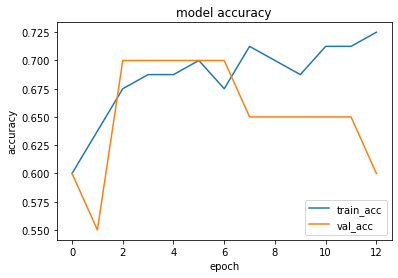

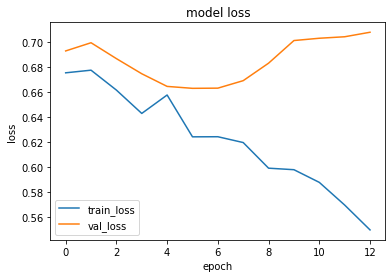

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.37155053]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.6040135]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.26026586]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.20241597]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.883821]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.22539338]]
Epoch 1/75
3/3 [==============================] - 1s 242ms/step - loss: 0.7002 - accuracy: 0.4750 - precision_133: 0.4561 - recall_133: 0.7027 - val_loss: 0.6722 - val_accuracy: 0.7500 - val_precision_133: 0.7857 - val_recall_133: 0.8462
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6623 - accuracy: 0.6500 - precision_133: 0.6000 - recall_133: 0.7297 - val_loss: 0.6774 - val_accuracy: 0.7000 - val_precision_133: 0.7692 - val_recall_133: 0.7692
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6512 - accuracy: 0.7125 - precision_133: 0.6591 - recall_133: 0.7838 - val_loss: 0.6651 - val_accuracy: 0.7000 - val_precision_133: 0.7692 - val_recall_133: 0.7692
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6383 - accuracy: 0.7250 - precision_133: 0.6667 - recall_133: 0.8108 - val_loss: 0.6501 - val_accuracy: 0.7000 - val_precision_133: 0.7692 - val_recall_133: 0.

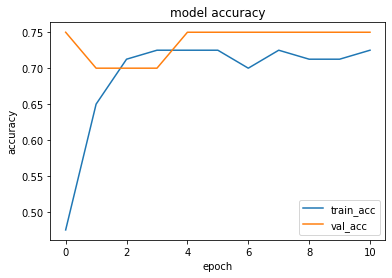

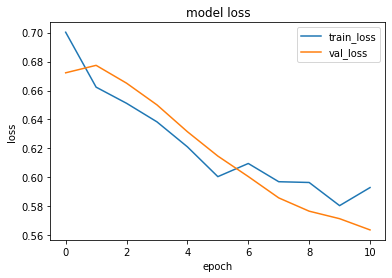

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.46283922]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.59639513]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.22317004]]


1it [00:00, 13315.25it/s]


prediction for video control_1.mov is [[0.06968901]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.828282]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.26152083]]
Epoch 1/75
3/3 [==============================] - 1s 252ms/step - loss: 0.7084 - accuracy: 0.4875 - precision_134: 0.4857 - recall_134: 0.4250 - val_loss: 0.6777 - val_accuracy: 0.8500 - val_precision_134: 0.8182 - val_recall_134: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6738 - accuracy: 0.6750 - precision_134: 0.6667 - recall_134: 0.7000 - val_loss: 0.6674 - val_accuracy: 0.8000 - val_precision_134: 0.7500 - val_recall_134: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6602 - accuracy: 0.7000 - precision_134: 0.6739 - recall_134: 0.7750 - val_loss: 0.6581 - val_accuracy: 0.8000 - val_precision_134: 0.7500 - val_recall_134: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6459 - accuracy: 0.6750 - precision_134: 0.6400 - recall_134: 0.8000 - val_loss: 0.6496 - val_accuracy: 0.8000 - val_precision_134: 0.7500 - val_recall_134: 0.

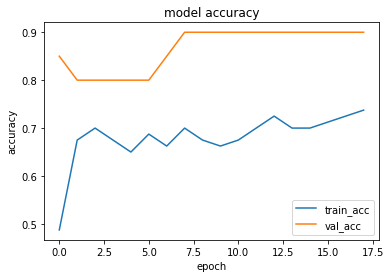

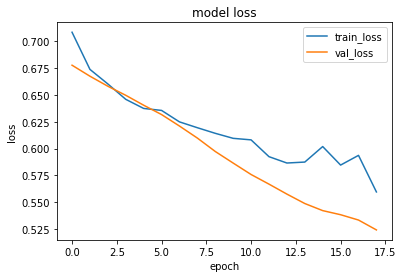

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.5701527]]


1it [00:00, 12372.58it/s]


prediction for video armflapping_3.mov is [[0.52588236]]


1it [00:00, 16578.28it/s]


prediction for video armflapping_2.mov is [[0.43953878]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.25576487]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.7351383]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.35774004]]


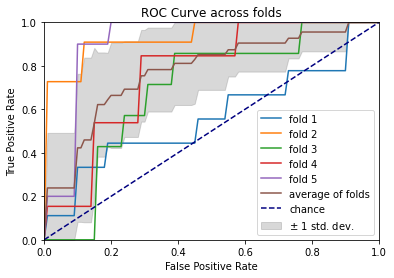

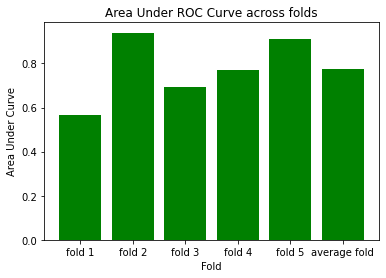

Epoch 1/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6836 - accuracy: 0.5125 - precision_136: 0.5179 - recall_136: 0.7073 - val_loss: 0.6921 - val_accuracy: 0.4500 - val_precision_136: 0.4500 - val_recall_136: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 193ms/step - loss: 0.6631 - accuracy: 0.6125 - precision_136: 0.5714 - recall_136: 0.9756 - val_loss: 0.6865 - val_accuracy: 0.5000 - val_precision_136: 0.4545 - val_recall_136: 0.5556
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6618 - accuracy: 0.7000 - precision_136: 0.6441 - recall_136: 0.9268 - val_loss: 0.6848 - val_accuracy: 0.5000 - val_precision_136: 0.4545 - val_recall_136: 0.5556
Epoch 4/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6605 - accuracy: 0.6375 - precision_136: 0.5968 - recall_136: 0.9024 - val_loss: 0.6861 - val_accuracy: 0.4500 - val_precision_136: 0.4000 - val_recall_136: 0.4444
Epoch 5/75
3/3 [==============================] 

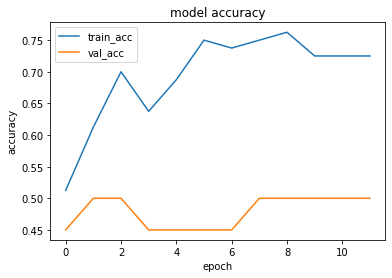

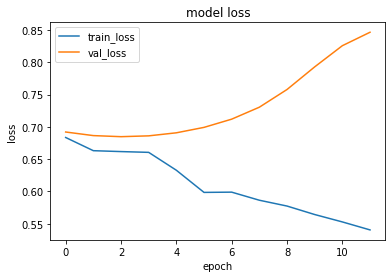

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.51981544]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.5120178]]


1it [00:00, 12300.01it/s]


prediction for video armflapping_2.mov is [[0.46095043]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.46642882]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.60951895]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.4800999]]
Epoch 1/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6874 - accuracy: 0.5125 - precision_137: 0.5000 - recall_137: 0.7179 - val_loss: 0.6493 - val_accuracy: 0.6500 - val_precision_137: 0.6111 - val_recall_137: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6656 - accuracy: 0.6750 - precision_137: 0.6444 - recall_137: 0.7436 - val_loss: 0.6295 - val_accuracy: 0.7000 - val_precision_137: 0.6471 - val_recall_137: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6611 - accuracy: 0.7000 - precision_137: 0.6667 - recall_137: 0.7692 - val_loss: 0.6099 - val_accuracy: 0.7000 - val_precision_137: 0.6471 - val_recall_137: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 171ms/step - loss: 0.6462 - accuracy: 0.7125 - precision_137: 0.6739 - recall_137: 0.7949 - val_loss: 0.5905 - val_accuracy: 0.7000 - val_precision_137: 0.6471 - val_recall_137: 1.0

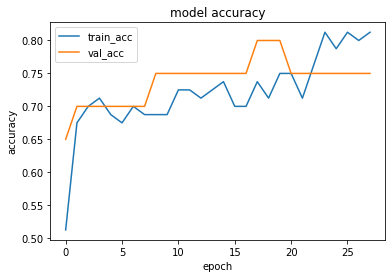

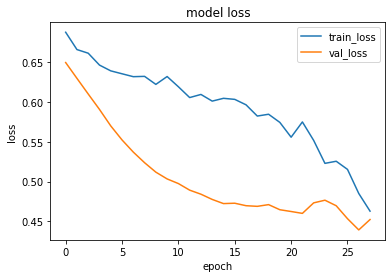

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.3793065]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.5742356]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.23055673]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.11306447]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.79629195]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.2556259]]
Epoch 1/75
3/3 [==============================] - 1s 251ms/step - loss: 0.6944 - accuracy: 0.4375 - precision_138: 0.4800 - recall_138: 0.5581 - val_loss: 0.7374 - val_accuracy: 0.3500 - val_precision_138: 0.3500 - val_recall_138: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6927 - accuracy: 0.4625 - precision_138: 0.5000 - recall_138: 0.8372 - val_loss: 0.7327 - val_accuracy: 0.3500 - val_precision_138: 0.3500 - val_recall_138: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6717 - accuracy: 0.5250 - precision_138: 0.5325 - recall_138: 0.9535 - val_loss: 0.7222 - val_accuracy: 0.3500 - val_precision_138: 0.3500 - val_recall_138: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6588 - accuracy: 0.5375 - precision_138: 0.5385 - recall_138: 0.9767 - val_loss: 0.7095 - val_accuracy: 0.4500 - val_precision_138: 0.3889 - val_recall_138: 1.0

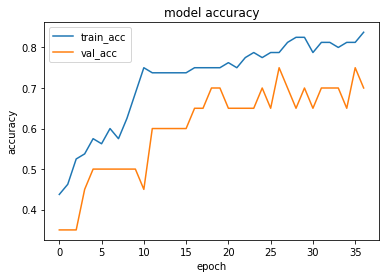

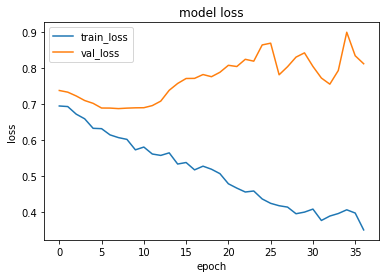

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.8930589]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.7108891]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.06271362]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.13918024]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.97505295]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.10077709]]
Epoch 1/75
3/3 [==============================] - 1s 239ms/step - loss: 0.6797 - accuracy: 0.6625 - precision_139: 0.5926 - recall_139: 0.8649 - val_loss: 0.6697 - val_accuracy: 0.7500 - val_precision_139: 0.7857 - val_recall_139: 0.8462
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6657 - accuracy: 0.6500 - precision_139: 0.6047 - recall_139: 0.7027 - val_loss: 0.6793 - val_accuracy: 0.7000 - val_precision_139: 0.7692 - val_recall_139: 0.7692
Epoch 3/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6656 - accuracy: 0.6750 - precision_139: 0.6341 - recall_139: 0.7027 - val_loss: 0.6827 - val_accuracy: 0.6500 - val_precision_139: 0.7500 - val_recall_139: 0.6923
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6512 - accuracy: 0.7500 - precision_139: 0.7179 - recall_139: 0.7568 - val_loss: 0.6781 - val_accuracy: 0.6500 - val_precision_139: 0.7500 - val_recall_139: 0.

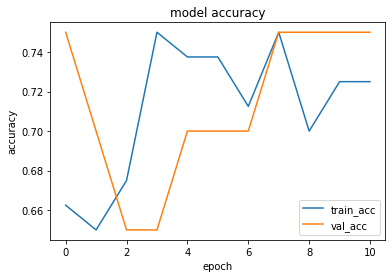

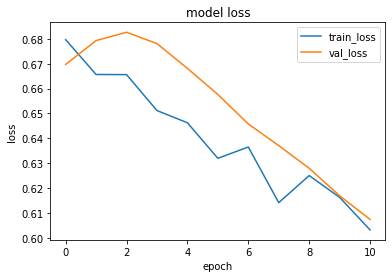

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.38261008]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.5379854]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.2750578]]


1it [00:00, 12192.74it/s]


prediction for video control_1.mov is [[0.11854532]]


1it [00:00, 16912.52it/s]


prediction for video control_2.mov is [[0.75401735]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.17388204]]
Epoch 1/75
3/3 [==============================] - 1s 249ms/step - loss: 0.6943 - accuracy: 0.4250 - precision_140: 0.4531 - recall_140: 0.7250 - val_loss: 0.6864 - val_accuracy: 0.4500 - val_precision_140: 0.4737 - val_recall_140: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6731 - accuracy: 0.5625 - precision_140: 0.5352 - recall_140: 0.9500 - val_loss: 0.6771 - val_accuracy: 0.5000 - val_precision_140: 0.5000 - val_recall_140: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6571 - accuracy: 0.5500 - precision_140: 0.5278 - recall_140: 0.9500 - val_loss: 0.6667 - val_accuracy: 0.5000 - val_precision_140: 0.5000 - val_recall_140: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6489 - accuracy: 0.5625 - precision_140: 0.5352 - recall_140: 0.9500 - val_loss: 0.6559 - val_accuracy: 0.5000 - val_precision_140: 0.5000 - val_recall_140: 1.

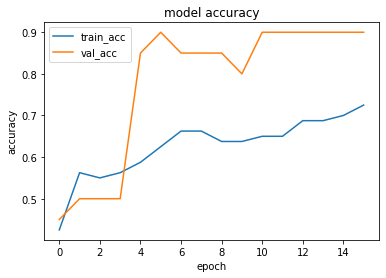

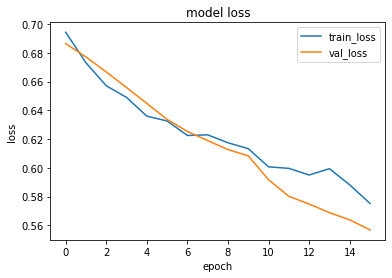

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.48037598]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_3.mov is [[0.52294666]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.33853477]]


1it [00:00, 11915.64it/s]


prediction for video control_1.mov is [[0.22618967]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.70354307]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.30138722]]


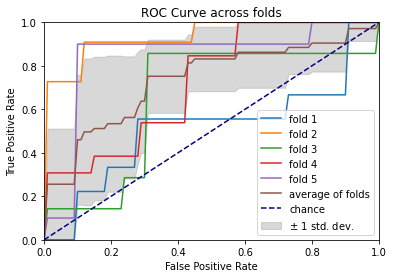

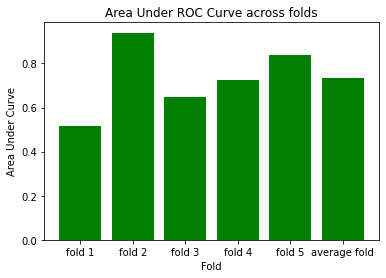

In [59]:
for run in range(10): 
    checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
    cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
# after running 10x, plot all the results 